<a href="https://colab.research.google.com/github/JASCRAJ/CCNet/blob/master/SlimSAM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone -b dev https://github.com/camenduru/SlimSAM
%cd /content/SlimSAM
!pip install -e .
!rm -rf /content/SlimSAM/checkpoints
!git clone https://huggingface.co/camenduru/SlimSAM /content/SlimSAM/checkpoints
!sed -i 's/input, approximate=self.approximate/input/g' /usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py
# !python inference.py

/content
Cloning into 'SlimSAM'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 282 (delta 35), reused 32 (delta 32), pack-reused 241 (from 1)
Receiving objects: 100% (282/282), 18.44 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/SlimSAM
Obtaining file:///content/SlimSAM
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment_anything
Cloning into '/content/SlimSAM/checkpoints'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (8/8), 1.09 KiB | 560.00 KiB/s, done.
Filtering content: 100% (3/3), 502.40 MiB | 26.00 MiB/s, done.


In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
from segment_anything_kd.modeling.image_encoder import add_decomposed_rel_pos
import matplotlib.pyplot as plt
import torch_pruning as tp

def calculate_iou(mask1, mask2):
    """
    Calculate Intersection over Union (IoU) for two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The IoU score.
    """
    # Make sure the input masks have the same shape
    assert mask1.shape == mask2.shape, "Both masks must have the same shape."

    # Calculate the intersection and union of the masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Compute the IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def test_model():

    device = torch.device("cuda")
    print("CUDA visible devices: " + str(torch.cuda.device_count()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name(device)))

    # teacher_model_type = 'vit_b'
    # checkpoint = 'checkpoints/sam_vit_b_qkv.pth'
    # teacher_model = sam_model_registry[teacher_model_type](checkpoint=checkpoint)
    # teacher_model.to(device)
    # teacher_model.eval()

    model_path = "checkpoints/SlimSAM-77.pth"
    SlimSAM_model = torch.load(model_path)
    SlimSAM_model.image_encoder = SlimSAM_model.image_encoder.module
    SlimSAM_model.to(device)
    SlimSAM_model.eval()
    print("model_path:",model_path)

    def forward(self, x):
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        for blk in self.blocks:
            x,qkv_emb,mid_emb,x_emb = blk(x)
        x = self.neck(x.permute(0, 3, 1, 2))
        return x

    import types
    funcType = types.MethodType
    SlimSAM_model.image_encoder.forward = funcType(forward, SlimSAM_model.image_encoder)
    example_inputs = torch.randn(1, 3, 1024, 1024).to(device)
    ori_macs, ori_size = tp.utils.count_ops_and_params(SlimSAM_model.image_encoder, example_inputs)
    print("MACs(G):",ori_macs/1e9,"Params(M):",ori_size/1e6)

    #mask_generator = SamAutomaticMaskGenerator(teacher_model)
    mask_generator = SamAutomaticMaskGenerator(
    model=SlimSAM_model,
    points_per_side=32,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
    predictor = SamPredictor(SlimSAM_model)

    with torch.no_grad():
        path = 'images/pavan.jpg'
        print(path)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image)

################ Segment everything prompt ################
        masks = mask_generator.generate(image)
        plt.figure(figsize=(15,10))
        plt.imshow(image)
        show_anns(masks)
        plt.axis('off')
        plt.show()
        plt.tight_layout()
        plt.savefig("images/"+"demo_everything" + ".png")

if __name__ == '__main__':
    test_model()

CUDA visible devices: 1
CUDA Device Name: Tesla T4
model_path: checkpoints/SlimSAM-77.pth


<ipython-input-3-07b4ce1ed761>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  SlimSAM_model = torch.load(model_path)


MACs(G): 21.457335252 Params(M): 5.78586
images/pavan.jpg


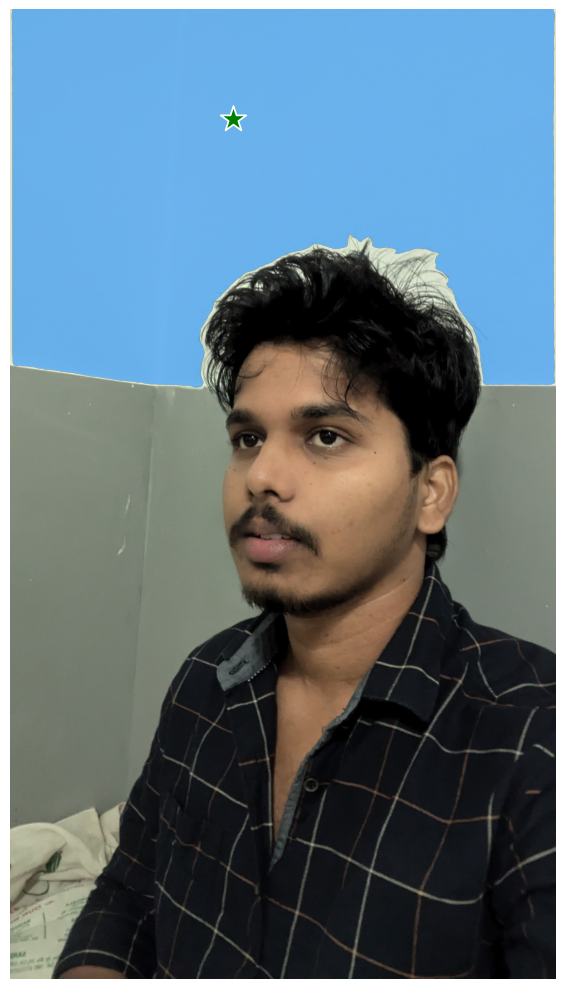

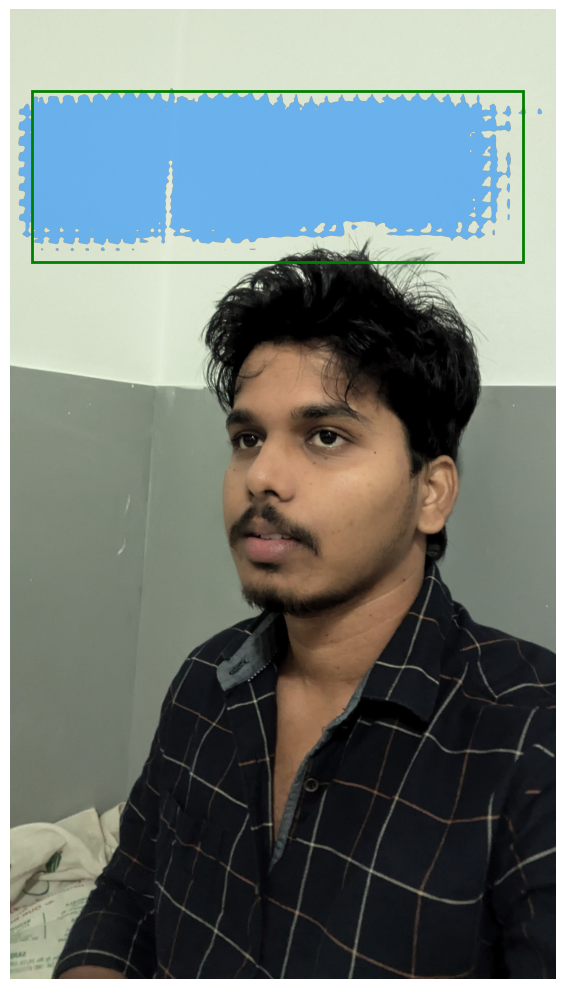

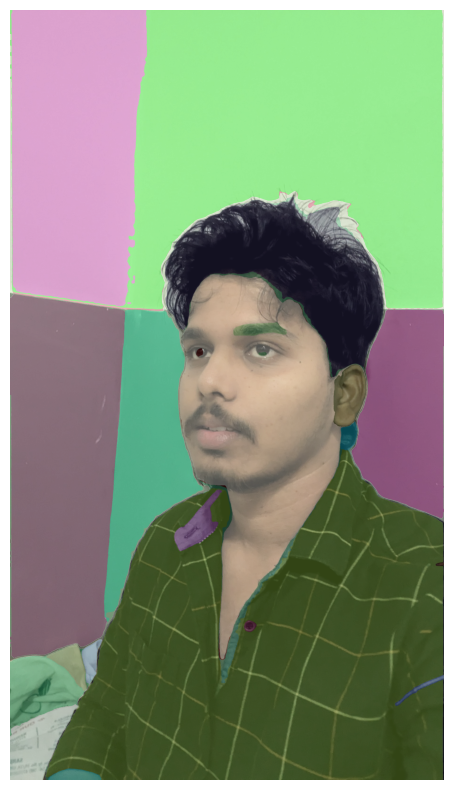

<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
from segment_anything_kd.modeling.image_encoder import add_decomposed_rel_pos
import matplotlib.pyplot as plt
import torch_pruning as tp

def calculate_iou(mask1, mask2):
    """
    Calculate Intersection over Union (IoU) for two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The IoU score.
    """
    # Make sure the input masks have the same shape
    assert mask1.shape == mask2.shape, "Both masks must have the same shape."

    # Calculate the intersection and union of the masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Compute the IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def test_model():

    device = torch.device("cuda")
    print("CUDA visible devices: " + str(torch.cuda.device_count()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name(device)))

    # teacher_model_type = 'vit_b'
    # checkpoint = 'checkpoints/sam_vit_b_qkv.pth'
    # teacher_model = sam_model_registry[teacher_model_type](checkpoint=checkpoint)
    # teacher_model.to(device)
    # teacher_model.eval()

    model_path = "checkpoints/SlimSAM-77.pth"
    SlimSAM_model = torch.load(model_path)
    SlimSAM_model.image_encoder = SlimSAM_model.image_encoder.module
    SlimSAM_model.to(device)
    SlimSAM_model.eval()
    print("model_path:",model_path)

    def forward(self, x):
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        for blk in self.blocks:
            x,qkv_emb,mid_emb,x_emb = blk(x)
        x = self.neck(x.permute(0, 3, 1, 2))
        return x

    import types
    funcType = types.MethodType
    SlimSAM_model.image_encoder.forward = funcType(forward, SlimSAM_model.image_encoder)
    example_inputs = torch.randn(1, 3, 1024, 1024).to(device)
    ori_macs, ori_size = tp.utils.count_ops_and_params(SlimSAM_model.image_encoder, example_inputs)
    print("MACs(G):",ori_macs/1e9,"Params(M):",ori_size/1e6)

    #mask_generator = SamAutomaticMaskGenerator(teacher_model)
    mask_generator = SamAutomaticMaskGenerator(
    model=SlimSAM_model,
    points_per_side=32,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
    predictor = SamPredictor(SlimSAM_model)

    with torch.no_grad():
        path = 'images/pavan.jpg'
        print(path)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image)

################ Point Prompt ################
        input_point = np.array([[750, 370]])
        input_label = np.array([1])
        masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box = None,
        multimask_output=False,
    )
        plt.figure(figsize=(15,10))
        plt.imshow(image)
        show_mask(masks, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        plt.tight_layout()
        plt.savefig("images/"+'demo_point' + ".png")

################ Box Prompt ################
        input_box = np.array([75, 275, 1725, 850])
        masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box = input_box,
        multimask_output=False,
    )
        plt.figure(figsize=(15,10))
        plt.imshow(image)
        show_mask(masks, plt.gca())
        show_box(input_box, plt.gca())
        plt.axis('off')
        plt.tight_layout()
        plt.savefig("images/"+'demo_box' + ".png")

################ Segment everything prompt ################
        masks = mask_generator.generate(image)
        plt.figure(figsize=(15,10))
        plt.imshow(image)
        show_anns(masks)
        plt.axis('off')
        plt.show()
        plt.tight_layout()
        plt.savefig("images/"+"demo_everything" + ".png")

if __name__ == '__main__':
    test_model()